In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import sklearn.datasets as datasets

# 文字列として表現されるデータの種類
テキストデータはそのままでは学習器で処理できず、前処理を加える必要がある。テキストデータの解析においては **情報検索 (information retrieval)** 、 **自然言語処理 (natural language processing)** の影響からデータセットは **コーパス** 、個々のデータを **文章** と呼ばれる。

* **カテゴリデータ**:  
  1 of k 符号化して扱える
* **意味的にはカテゴリに分類できる文字列**  
  1 of k 符号化。スペルミスや意味不明な記入があるため、可能ならばカテゴリデータとして収集すること
* **構造化された文字列**  
  住所などの構造。扱う構造ごとに考える必要がある。書籍では扱われていない。
* **テキストデータ**  
  自由に書かれたテキスト。書籍では主にこれを扱う。

# 映画レビューのサンプルデータ
http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
reviews_train = datasets.load_files("../aclImdb/train/")

In [4]:
import re

# ロード
regex_br = re.compile("<br */?>")
text_data = [regex_br.sub("", line.decode("utf8")) for line in reviews_train.data]
text_target = reviews_train.target

# データを訓練・テストに分離
text_train_data, text_test_data, text_train_target, text_test_target = train_test_split(text_data, text_target)

# Bag of Words (BoW) によるテキスト表現
文章を単語で分解し単語毎の出現回数をベクトル成分として出せば機械学習で処理できる。CountVectorizer を用いて文章をBoW表現へ変換できる。

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

bards_words = ["The fool doth think he is wise,", "but the wise man knows kimself to be a fool"]
vect = CountVectorizer()
vect.fit_transform(bards_words)

# 単語と添字の対応表
print(vect.vocabulary_)

# BoW表現への変換
print(vect.transform(bards_words).toarray())

{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 5, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'kimself': 6, 'to': 11, 'be': 0}
[[0 0 1 1 1 1 0 0 0 1 1 0 1]
 [1 1 0 1 0 0 1 1 1 1 0 1 1]]


注意点は以下の通り。

* 単語の順番は出力へ反映されない
* 意味が同じ単語でも、単数形・複数形などは別ものとして扱われる
* 唯の数値など、学習器では意味を持たないものもボキャブラリとして扱われる

BoW表現は高次元で疎なデータとなるために線形モデルが有効。ロジスティクス回帰で映画レビューの文章の評判を、肯定的・否定的の2種に分類する。

In [6]:
est = make_pipeline(CountVectorizer(), LogisticRegression(solver="lbfgs", max_iter=1000))
est.fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))
print("vocabulary count: ", len(est.steps[0][1].vocabulary_))

score:  0.88128
vocabulary count:  67594


上記のコードでは数字など情報量の少ないものも出力ベクトルの成分になるが、学習時の負荷やモデル解釈の難易度が上昇する。
scikit-learn ではmin_dfを用いる事で出現回数が一定値未満の単語をボキャブラリに加えない事が可能。

In [7]:
est = make_pipeline(CountVectorizer(min_df=5), LogisticRegression(solver="lbfgs", max_iter=1000))
est.fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))
print("vocabulary count: ", len(est.steps[0][1].vocabulary_))

score:  0.88048
vocabulary count:  23728


# モデル係数を見てみる
ロジスティクス回帰の係数を可視化する。ネガティブレビューが0、ポジティブレビューが1のため、負の係数はネガティブレビューとの関連が深くなる。数字など役に立たない単語が入っており、解釈がしにくいことが分かる。

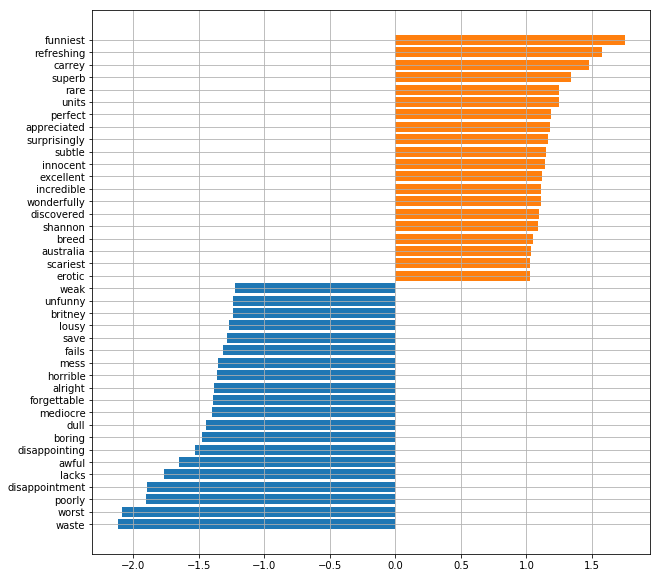

In [8]:
logreg = est.steps[1][1]

# 重み上位下位それぞれ20個 (昇順)
coef_idx_sorted = np.argsort(logreg.coef_, axis=1).ravel()
coef_idx_sorted = np.concatenate((coef_idx_sorted[:20], coef_idx_sorted[-20:]))
coef_sorted = logreg.coef_[0, coef_idx_sorted]

# 表示用単語リスト
bow = est.steps[0][1]
features = np.array(bow.get_feature_names())

colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 10), facecolor="white")
plt.barh(np.arange(40), coef_sorted, color=colors(coef_sorted >= 0))
plt.yticks(range(40), labels=features[coef_idx_sorted])
plt.grid()
plt.show()

# ストップワード
役に立たない単語を取り除く方法として、データセットのサイズが小さい場合には一般的な単語をストップワードとして除外する手法がある。 scikit-learn ではストップワードをリストとして渡せるほか、"english"と指定すると英語用の組込みストップワードが使用できる。

In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(repr(ENGLISH_STOP_WORDS))

frozenset({'beyond', 'whither', 'side', 'every', 'then', 'there', 'thereby', 'two', 'de', 'back', 'how', 'seemed', 'itself', 'about', 'many', 'most', 'me', 'via', 'none', 'above', 'under', 'whose', 'have', 'down', 'enough', 'before', 'into', 'mine', 'towards', 'un', 'their', 'eg', 'mill', 'five', 'am', 'or', 'six', 'more', 'within', 'per', 'why', 'con', 'from', 'noone', 'each', 'last', 'off', 'thereupon', 'with', 'should', 'could', 'elsewhere', 'sometimes', 'alone', 're', 'sincere', 'part', 'other', 'several', 'all', 'whence', 'behind', 'than', 'besides', 'always', 'etc', 'though', 'hasnt', 'ever', 'where', 'you', 'everyone', 'herself', 'on', 'never', 'therefore', 'whereby', 'next', 'inc', 'otherwise', 'seems', 'sometime', 'throughout', 'namely', 'one', 'yourselves', 'becoming', 'empty', 'what', 'nor', 'until', 'do', 'except', 'fire', 'often', 'few', 'name', 'top', 'another', 'either', 'find', 'others', 'seeming', 'no', 'us', 'forty', 'an', 'anyway', 'interest', 'myself', 'therein', 'w

In [10]:
est = make_pipeline(CountVectorizer(min_df=5, stop_words="english"), LogisticRegression(solver="lbfgs", max_iter=1000))
est.fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))
print("vocabulary count: ", len(est.steps[0][1].vocabulary_))

score:  0.8704
vocabulary count:  23425


# tf-idfを用いたデータのスケール変換
役に立たない単語への対処として、特徴量が持つ情報量に応じて特徴量のスケール変換を行う手法が有る。一般的な手法に **tf-idf** があり、特定文章に頻出し他文章にはあまり現れない単語は対象文章の内容をよく表しているという発想を元にしている。これは教師なし学習であるため、重要さは本来の解きたい問題での重要さではなく、データ中の特異さである事に注意。

$$\begin{align}
    \mathit{tfidf} &= \mathit{tf} \cdot \mathit{idf} \\
    \mathit{tf}    &= \frac{\rm 文章A中の対象単語の出現回数}{\rm 全文章中の単語Wの出現回数} \\
    \mathit{idf}   &= \frac{\rm 全文章の数}{\rm 単語Wの出現する文章の数}
\end{align}$$

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

est = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(solver="lbfgs", max_iter=1000)).fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))

score:  0.88816


tf-idfが低い特徴量は多くの文章に共通して出現するか、あまり出現しないか、非常に長い文章にしか出現しないかとなる。一方の高い特徴量には lupin(ルパン), zatoichi(座頭市), pokemon(ポケモン) など特定の映画に関連があるものが出てくる。これは当該単語が特定作品のレビューで頻繁に出現するからと推測できる。

In [12]:
tfidf = est.steps[0][1]
data = tfidf.transform(text_train_data)

In [13]:
word_idx_sorted_tfidf = np.max(data, axis=0).toarray().ravel()
word_idx_sorted_tfidf = np.argsort(word_idx_sorted_tfidf)
features = np.array(tfidf.get_feature_names())

print("tfidfが低い特徴量 20個\n", features[word_idx_sorted_tfidf[:20]])
print("tfidfが高い特徴量 20個\n", features[word_idx_sorted_tfidf[-20:]])

tfidfが低い特徴量 20個
 ['cenamatch' 'speared' 'crossface' 'somersaulted' 'wassup' 'somersaulting'
 'stormmatch' 'turnbuckles' 'riksihi' 'clotheslining' 'lesnar' 'rollup'
 'sprinted' 'tannouncement' 'networking' 'hardymatch' 'hurracanrana'
 'superkicked' 'pinfall' 'rvdmatch']
tfidfが高い特徴量 20個
 ['othello' 'muppet' 'dalmations' 'gadget' 'blah' 'woo' 'lennon' 'zatoichi'
 'sucks' 'bye' 'botched' 'doodlebops' 'steve' 'darkman' 'wei' 'lupin'
 'smallville' 'nr' 'scanners' 'pokemon']


idfが低い特徴量も出せる。低い特徴量には様々な文章で頻出する単語が出るが、先程のストップワードが多数出ることが分かる。

In [14]:
word_idx_sorted_idf = np.argsort(tfidf.idf_)
features = np.array(tfidf.get_feature_names())

print("idfが低い特徴量 20個\n", features[word_idx_sorted_idf[:20]])
print("idfが高い特徴量 20個\n", features[word_idx_sorted_idf[-20:]])

idfが低い特徴量 20個
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'be' 'one']
idfが高い特徴量 20個
 ['minmay' 'minka' 'minium' 'ministro' 'campout' 'minimalistically'
 'minimises' 'minimising' 'minimizing' 'campmates' 'minigenre' 'minimums'
 'campiest' 'miniskirt' 'miniskirts' 'ministering' 'ministers'
 'ministrations' 'campily' 'üvegtigris']


# 1単語よりも大きい単位のBoW
BoWは単語の順番が失われる。順番を考慮するための手法として2, 3個の連続した単語をBoWとして扱う **n-gram** が知られている。1単語で unigram 、2単語で **bigram** 、3単語で trigram と呼ばれる。範囲の最小値1、最大値は5までは性能向上する可能性がある。しかし、数を増やすのは特徴量の爆発や過学習に注意する必要がある。

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

est = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    LogisticRegression(solver="lbfgs", max_iter=1000)).fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))
print("vocabulary count: ", len(est.steps[0][1].vocabulary_))

score:  0.88336
vocabulary count:  1237753


# より進んだトークン分割、語幹処理、見出し語化
BoWモデル構築の最初のトークン分割でも出来ることはある。英単語では単数形、複数形は意味的に同じものとして扱う方が良い。この様なものは単語の **語幹(word stem)** や **見出し語(lemma)** を用いた表現に変換すれば解決する。ルールベースのヒューリスティクスで行う場合は **語幹処理(stemming)** と呼び、辞書を用いた場合には **見出し語化(lemmatization)** と呼ぶ。見出し語化は辞書にあれば元と派生語を区別する事ができる点がステミングと異なる。いずれも **正規化** の一種といえる。

In [16]:
import spacy

# 見出し語化を行う
nlp = spacy.load("ja_ginza_nopn")
doc = nlp("吾輩は猫である。ﾈｺと和解せよ。")

In [17]:
pd.DataFrame([(x.text, x.lemma_, x.pos_) for x in doc], columns=("text", "lemma", "pos"))

,text,lemma,pos
0,吾輩,我が輩,PRON
1,は,は,ADP
2,猫,猫,NOUN
3,で,だ,AUX
4,ある,有る,AUX
5,。,。,PUNCT
6,ﾈｺ,猫,NOUN
7,と,と,ADP
8,和解,和解,NOUN
9,せよ,為る,AUX


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# pipenv run python -m spacy link en_core_web_sm en_core_web_sm
nlp = spacy.load("en_core_web_sm")

def tokenizer(doc):
    return tuple(token.lemma_ for token in nlp(doc, disable=["parser", "tagger"]))

est = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer),
    LogisticRegression(solver="lbfgs", max_iter=1000)).fit(text_train_data, text_train_target)

print("score: ", est.score(text_test_data, text_test_target))
print("vocabulary count: ", len(est.steps[0][1].vocabulary_))

score:  0.88128
vocabulary count:  1025920


# トピックモデリングと文章クラスタリング
テキストデータへ用いられる処理の1つに **トピックモデリング(topic modeling)** がある。これは通常は教師なし学習で、文章に対して1つ以上の **トピック(topic)** を割当てるタスクを指す (ニュースにおける「政治」「スポーツ」「金融」 etc)。トピックが1つならばクラスタリング、複数ならば成分分析に関係するが、多くの場合には **LDA(Latent Dirichlet Allocation)** と呼ばれる成分分析手法を指す。

LDAは同時に現れる頻度の高い単語の集合(トピック)を探す。抽出できるトピックは教師なし学習であるためPCAやNMFの成分に近く、解釈できるものとは限らない。

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

est = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LatentDirichletAllocation(n_components=10, random_state=0))
est.fit(text_train_data)
pass

In [26]:
vec, lda = est.steps[0][1], est.steps[1][1]
relativeIdx = np.argsort(lda.components_, axis=1)[:,:-10:-1]

In [27]:
words = np.array(vec.get_feature_names())
words = words[relativeIdx].T
heads = [f"topic {i}" for i in range(words.shape[1])]

pd.DataFrame(words, columns=heads)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,the,scrooge,smallville,scorsese,hip hop,leonora,ramones,artemisia,hartley,major payne
1,and,zizek,wwe,streisand,vance,nr,the ramones,snowman,darius,the rose
2,of,dalton,mabel,dahmer,blaise,moto,grinch,wei,puerto,doris
3,to,jim jones,of smallville,ants,philo,streisand,the grinch,streisand,henry fool,mcdoakes
4,is,zelah,newcombe,roeg,philo vance,sibling,soderbergh,picker,hip hop,kidman
5,it,boothe,health,hammerhead,modesty blaise,archie,che,the nostril,fay grim,in spain
6,in,john ritter,ashraf,lila,anchors,man to,bernsen,nostril picker,goldsworthy,the rock
7,this,kusturica,cody,health,john ritter,movie filled,dahmer,zizek,beetle,blandings
8,that,jackass,kidman,one really,zenia,pauline,sox,nostril,will like,only complaint


# その他キーワード
* nltk
* gensim